# Mass Transfer Lab COMSOL Data Analysis

#### Import libraries 

In [100]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import linregress
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import interp1d

#### Reading csv data and cleaning

In [120]:
df_123 = pd.read_csv('123_data.csv')
df_128 = pd.read_csv('128_data.csv')
df_133 = pd.read_csv('133_data.csv')
df_140 = pd.read_csv('140_data.csv')

df_123_flux = pd.read_csv('123-flux-data.csv')
df_128_flux = pd.read_csv('128-flux-data.csv')
df_133_flux = pd.read_csv('133-flux-data.csv')
df_140_flux = pd.read_csv('140-flux-data.csv')

def cleaner(df):
    df = df.dropna()
    df = df.rename(columns=df.iloc[0]).drop(df.index[0]).reset_index(drop=True)
    df = df.apply(pd.to_numeric, errors='coerce')
    df = df.rename(columns={"% x": "x (m)", "y": "y (m)", "cd.ndflux_c (mol/(m^2*s))": "molar flux"})
    return df

df_123 = cleaner(df_123)
df_128 = cleaner(df_128)
df_133 = cleaner(df_133)
df_140 = cleaner(df_140)

df_123_flux = cleaner(df_123_flux)
df_128_flux = cleaner(df_128_flux)
df_133_flux = cleaner(df_133_flux)
df_140_flux = cleaner(df_140_flux)

df_123.head()

,x (m),y (m),T (K),c (mol/m^3)
0,0.000000,0.001165,316.538890,0.000000
1,0.000000,0.000547,316.538890,0.000000
2,0.000889,0.000946,316.531245,0.000914
3,0.001411,0.001557,316.537820,0.000152
4,0.000000,0.002294,316.538890,0.000000


#### Dataframe for COMSOL parameters

In [102]:
flux_data = [-0.0017986, -0.0019379, -0.0020889, -0.0019698]
mflux_df = pd.DataFrame(flux_data, columns=["molar flux"])
mflux_df['air velocity (m/s)'] = [1.95072, 1.31064, 1.22936, 0.91948]
COMSOL_para = mflux_df
COMSOL_para

,molar flux,air velocity (m/s)
0,-0.001799,1.95072
1,-0.001938,1.31064
2,-0.002089,1.22936
3,-0.001970,0.91948


# Analysis Question 2
Determine the thicknesses of both thermal and concentration boundary layers and how they
vary with position x (at a fixed velocity) as well as with velocity (at a fixed position or
average along various positions). Clearly describe how you determine the boundary-layer
thickness. Explain the trends and what you expect based on theory, and the physical
reasoning of such trends. Please avoid nonlinear fits (because in general they do not
guarantee a unique solution and can be difficult to judge visually because subtleties in
curvature can be unobvious) and instead linearize your equations so as to enable use of
linear least-squares regression (which has a unique solution and is intuitive to judge
visually).

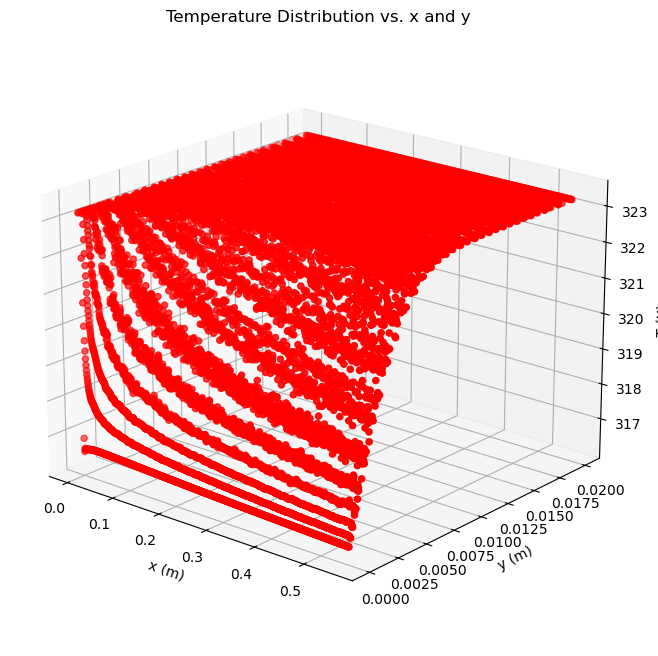

In [103]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot of the data points
ax.scatter(df_140['x (m)'], df_140['y (m)'], df_140['T (K)'], c='r', marker='o')

# Set labels for the axes
ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')
ax.set_zlabel('T (K)')

# Set a title for the plot
ax.set_title('Temperature Distribution vs. x and y')

# Rotate the plot for better visualization (optional)
ax.view_init(elev=20, azim=-50)  # Adjust elevation and azimuth angles

# Display the plot
plt.show()

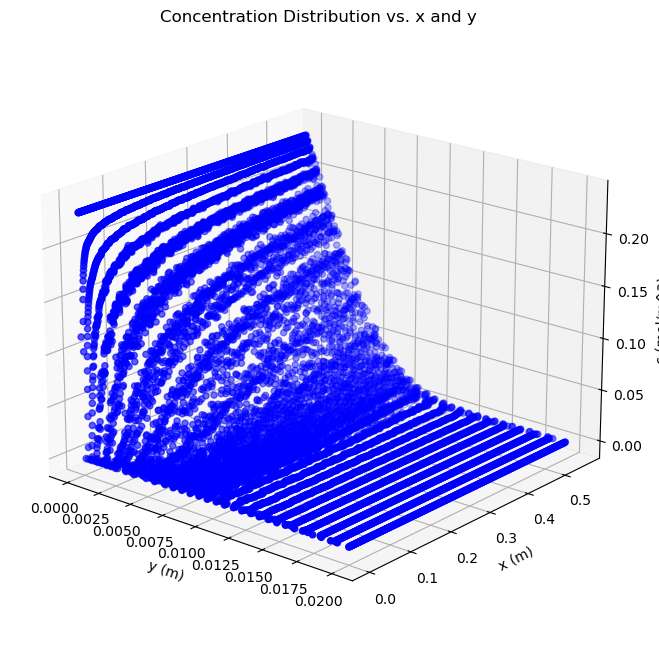

In [104]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot of the data points
ax.scatter(df_140['y (m)'], df_140['x (m)'], df_140['c (mol/m^3)'], c='b', marker='o')

# Set labels for the axes
ax.set_xlabel('y (m)')
ax.set_ylabel('x (m)')
ax.set_zlabel('c (mol/m^3)')

# Set a title for the plot
ax.set_title('Concentration Distribution vs. x and y')

# Rotate the plot for better visualization (optional)
ax.view_init(elev=20, azim=-50)  # Adjust elevation and azimuth angles

# Display the plot
plt.show()

#### Thermal Boundary Layer Thickness Determination

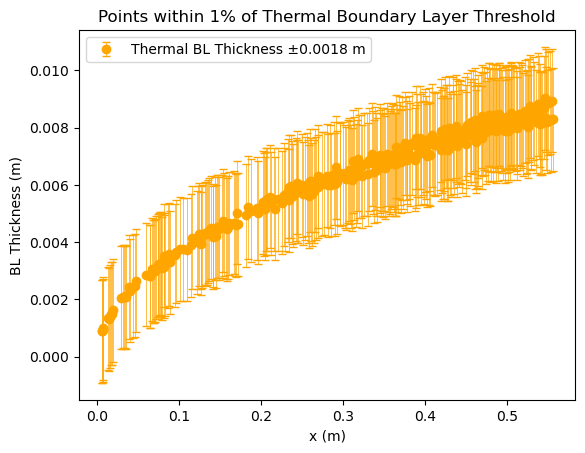

In [105]:
def get_T_BL_thickness(df):
    T_max = df["T (K)"].max()
    T_min = df["T (K)"].min()
    delta_T = T_max - T_min
    T_threshold = T_min + 0.99 * delta_T
    T_lower_bound = T_threshold - 0.01 * delta_T

    filtered_df = df[(df["T (K)"] >= T_lower_bound) & (df["T (K)"] <= T_threshold)]
    return filtered_df["x (m)"], filtered_df["y (m)"]

BL_thermal_140_x, BL_thermal_140_y = get_T_BL_thickness(df_140)

y_error_thermal = np.full_like(BL_thermal_140_y, 0.0018)
plt.errorbar(BL_thermal_140_x, BL_thermal_140_y, yerr=y_error_thermal, fmt='o', color="orange",
             ecolor='orange', capsize=3, linewidth = 0.5, label="Thermal BL Thickness ±0.0018 m")
plt.xlabel("x (m)")
plt.ylabel("BL Thickness (m)")
plt.title("Points within 1% of Thermal Boundary Layer Threshold")
plt.legend()
plt.show()

#### For the smallest air velocity

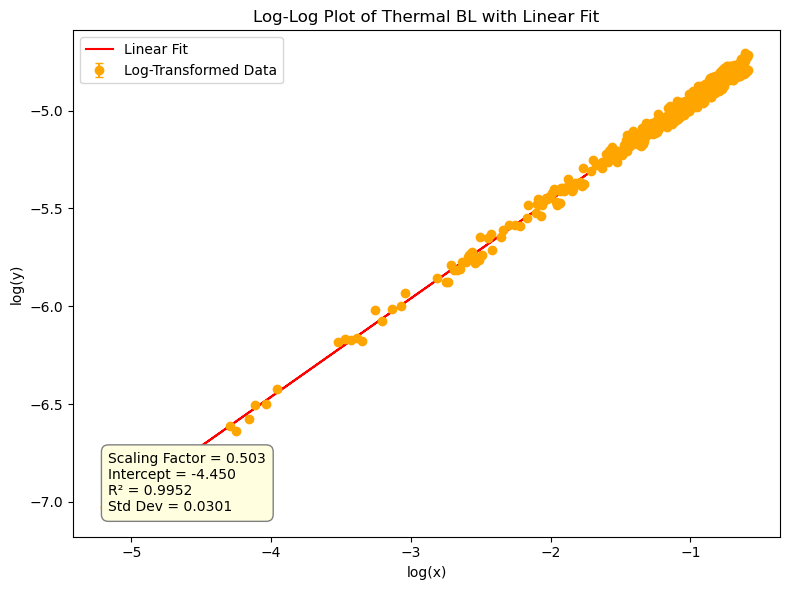

In [106]:
mask = (BL_thermal_140_x > 0) & (BL_thermal_140_y > 0)
x_log = np.log(BL_thermal_140_x[mask])
y_log = np.log(BL_thermal_140_y[mask])

log_y_error = y_error_thermal / abs(y_log)

slope, intercept, r_value, p_value, std_err = linregress(x_log, y_log)
y_fit = slope * x_log + intercept

residuals = y_log - y_fit
std_dev = np.std(residuals)

plt.figure(figsize=(8, 6))
plt.errorbar(x_log, y_log, yerr=log_y_error, fmt='o', color="orange",
             ecolor='orange', capsize=3, label="Log-Transformed Data")
plt.plot(x_log, y_fit, color="red", label="Linear Fit")

# Annotate fit parameters
annotation = (f"Scaling Factor = {slope:.3f}\n"
              f"Intercept = {intercept:.3f}\n"
              f"R² = {r_value**2:.4f}\n"
              f"Std Dev = {std_dev:.4f}")
plt.annotate(annotation, xy=(0.05, 0.05), xycoords="axes fraction",
             fontsize=10, bbox=dict(boxstyle="round,pad=0.5", fc="lightyellow", ec="gray"))

plt.xlabel("log(x)")
plt.ylabel("log(y)")
plt.title("Log-Log Plot of Thermal BL with Linear Fit")
plt.legend()
plt.tight_layout()
plt.show()

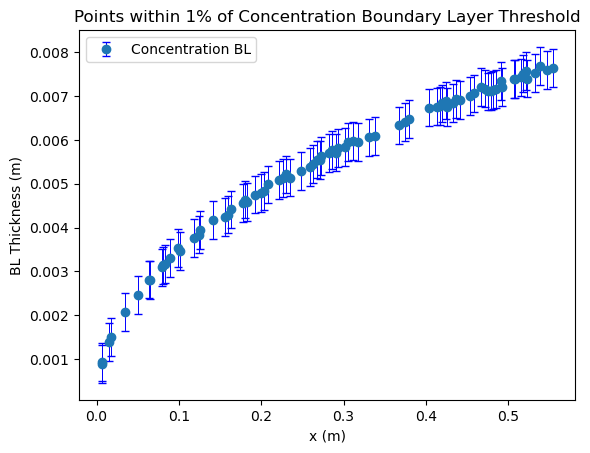

In [107]:
def get_c_BL_thickness(df):
    c_max = df["c (mol/m^3)"].max()
    c_min = df["c (mol/m^3)"].min()
    delta_c = c_max - c_min
    c_threshold = c_min + (0.1 * delta_c)
    c_lower_bound = c_threshold - 0.01 * delta_c

    filtered_df = df[(df["c (mol/m^3)"] >= c_lower_bound) & (df["c (mol/m^3)"] <= c_threshold)]
    return filtered_df["x (m)"], filtered_df["y (m)"]

BL_concentration_140_x, BL_concentration_140_y = get_c_BL_thickness(df_140)

y_error = np.full_like(BL_concentration_140_y, 0.00043)

plt.errorbar(BL_concentration_140_x, BL_concentration_140_y, yerr=y_error, fmt='o',
             ecolor='blue', capsize=3, linewidth=0.7, label="Concentration BL")

plt.xlabel("x (m)")
plt.ylabel("BL Thickness (m)")
plt.title("Points within 1% of Concentration Boundary Layer Threshold")
plt.legend()
plt.show()

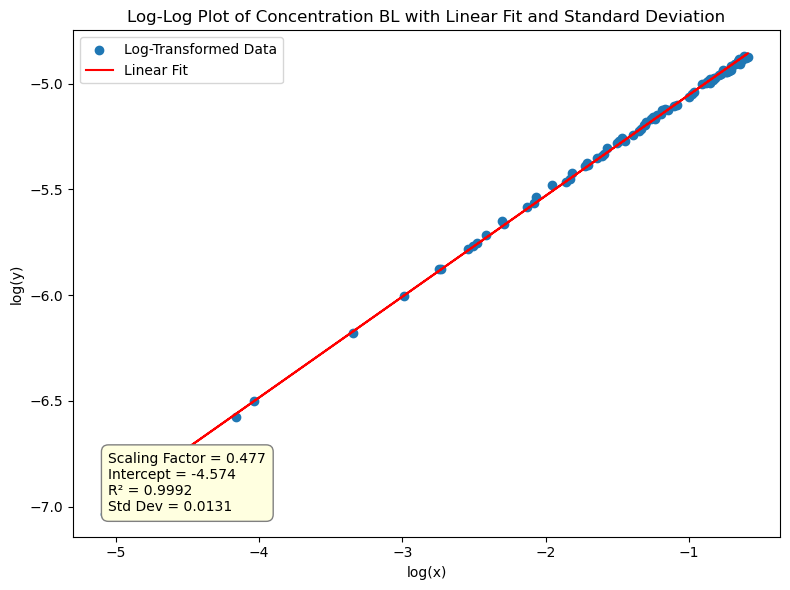

In [108]:
mask1 = (BL_concentration_140_x > 0) & (BL_concentration_140_y > 0)
x_log = np.log(BL_concentration_140_x[mask1])
y_log = np.log(BL_concentration_140_y[mask1])

# Perform linear regression on log-log data
slope, intercept, r_value, p_value, std_err = linregress(x_log, y_log)
y_fit = slope * x_log + intercept

# Compute residuals and standard deviation
residuals = y_log - y_fit
std_dev = np.std(residuals)

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(x_log, y_log, label="Log-Transformed Data")
plt.plot(x_log, y_fit, color="red", label="Linear Fit")

# Annotate fit parameters
annotation = (f"Scaling Factor = {slope:.3f}\n"
              f"Intercept = {intercept:.3f}\n"
              f"R² = {r_value**2:.4f}\n"
              f"Std Dev = {std_dev:.4f}")
plt.annotate(annotation, xy=(0.05, 0.05), xycoords="axes fraction",
             fontsize=10, bbox=dict(boxstyle="round,pad=0.5", fc="lightyellow", ec="gray"))

plt.xlabel("log(x)")
plt.ylabel("log(y)")
plt.title("Log-Log Plot of Concentration BL with Linear Fit and Standard Deviation")
plt.legend()
plt.tight_layout()
plt.show()

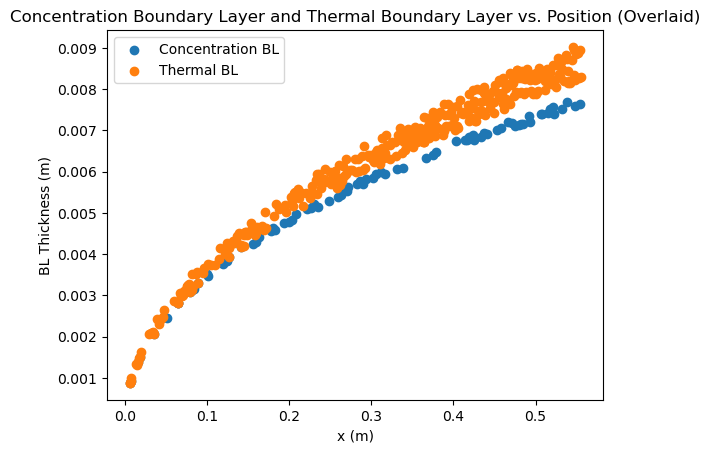

In [109]:
plt.scatter(BL_concentration_140_x, BL_concentration_140_y)
plt.scatter(BL_thermal_140_x, BL_thermal_140_y)
plt.xlabel("x (m)")
plt.ylabel("BL Thickness (m)")
plt.title("Concentration Boundary Layer and Thermal Boundary Layer vs. Position (Overlaid)")
plt.legend(["Concentration BL", "Thermal BL"])
plt.show()

In [110]:
BL_thermal_128_x, BL_thermal_128_y = get_T_BL_thickness(df_128)
BL_thermal_133_x, BL_thermal_133_y = get_T_BL_thickness(df_133)
BL_thermal_140_x, BL_thermal_140_y = get_T_BL_thickness(df_140)

BL_concentration_128_x, BL_concentration_128_y = get_c_BL_thickness(df_128)
BL_concentration_133_x, BL_concentration_133_y = get_c_BL_thickness(df_133)
BL_concentration_140_x, BL_concentration_140_y = get_c_BL_thickness(df_140)

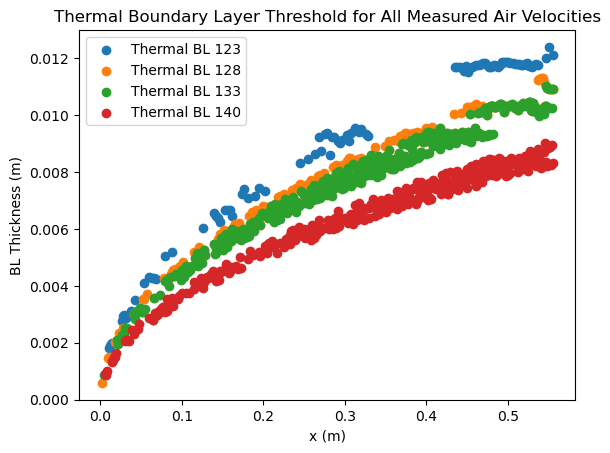

In [111]:
plt.scatter(BL_thermal_123_x, BL_thermal_123_y)
plt.scatter(BL_thermal_128_x, BL_thermal_128_y)
plt.scatter(BL_thermal_133_x, BL_thermal_133_y)
plt.scatter(BL_thermal_140_x, BL_thermal_140_y)
plt.xlabel("x (m)")
plt.ylabel("BL Thickness (m)")
plt.title("Thermal Boundary Layer Threshold for All Measured Air Velocities")
plt.legend(["Thermal BL 123", "Thermal BL 128", "Thermal BL 133", "Thermal BL 140"])
plt.show()

In [112]:
# this is to narrow the range of x values that are considered when calculating our average BL thickness
# since we don't have an x value that contains data for all of the air speeds
lower_bound = 0.25
upper_bound = 0.32
filter_for_thermal_BL_123 = (BL_thermal_123_x >= lower_bound) & (BL_thermal_123_x <= upper_bound)
filter_for_thermal_BL_128 = (BL_thermal_128_x >= lower_bound) & (BL_thermal_128_x <= upper_bound)
filter_for_thermal_BL_133 = (BL_thermal_133_x >= lower_bound) & (BL_thermal_133_x <= upper_bound)
filter_for_thermal_BL_140 = (BL_thermal_140_x >= lower_bound) & (BL_thermal_140_x <= upper_bound)

avg_thermal_BL_123 = BL_thermal_123_y[filter_for_thermal_BL_123].mean()
avg_thermal_BL_128 = BL_thermal_128_y[filter_for_thermal_BL_128].mean()
avg_thermal_BL_133 = BL_thermal_133_y[filter_for_thermal_BL_133].mean()
avg_thermal_BL_140 = BL_thermal_140_y[filter_for_thermal_BL_140].mean()

print("Average thermal Boundary Layer for 123ºF =", avg_thermal_BL_123)
print("Average thermal Boundary Layer for 128ºF =", avg_thermal_BL_128)
print("Average thermal Boundary Layer for 133ºF =", avg_thermal_BL_133)
print("Average thermal Boundary Layer for 140ºF =", avg_thermal_BL_140)

Average thermal Boundary Layer for 123ºF = 0.009105356321000001
Average thermal Boundary Layer for 128ºF = 0.007851251865781818
Average thermal Boundary Layer for 133ºF = 0.007573749988862744
Average thermal Boundary Layer for 140ºF = 0.006195004269625


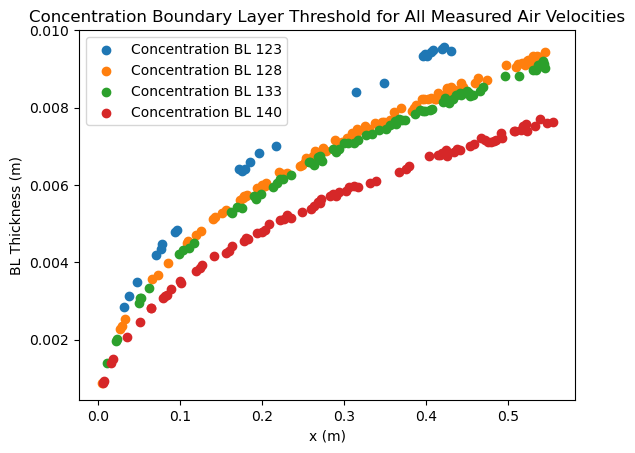

In [113]:
plt.scatter(BL_concentration_123_x, BL_concentration_123_y)
plt.scatter(BL_concentration_128_x, BL_concentration_128_y)
plt.scatter(BL_concentration_133_x, BL_concentration_133_y)
plt.scatter(BL_concentration_140_x, BL_concentration_140_y)
plt.xlabel("x (m)")
plt.ylabel("BL Thickness (m)")
plt.title("Concentration Boundary Layer Threshold for All Measured Air Velocities")
plt.legend(["Concentration BL 123", "Concentration BL 128", "Concentration BL 133", "Concentration BL 140"])
plt.show()

In [114]:
# this is to narrow the range of x values that are considered when calculating our average BL thickness
# since we don't have an x value that contains data for all of the air speeds
lower_bound1 = 0.25
upper_bound1 = 0.32
filter_for_concentration_BL_123 = (BL_concentration_123_x >= lower_bound1) & (BL_concentration_123_x <= upper_bound1)
filter_for_concentration_BL_128 = (BL_concentration_128_x >= lower_bound1) & (BL_concentration_128_x <= upper_bound1)
filter_for_concentration_BL_133 = (BL_concentration_133_x >= lower_bound1) & (BL_concentration_133_x <= upper_bound1)
filter_for_concentration_BL_140 = (BL_concentration_140_x >= lower_bound1) & (BL_concentration_140_x <= upper_bound1)

avg_concentration_BL_123 = BL_concentration_123_y[filter_for_concentration_BL_123].mean()
avg_concentration_BL_128 = BL_concentration_128_y[filter_for_concentration_BL_128].mean()
avg_concentration_BL_133 = BL_concentration_133_y[filter_for_concentration_BL_133].mean()
avg_concentration_BL_140 = BL_concentration_140_y[filter_for_concentration_BL_140].mean()


print("Average concentration Boundary Layer for 123ºF =", avg_concentration_BL_123)
print("Average concentration Boundary Layer for 128ºF =", avg_concentration_BL_128)
print("Average concentration Boundary Layer for 133ºF =", avg_concentration_BL_133)
print("Average concentration Boundary Layer for 140ºF =", avg_concentration_BL_140)

Average concentration Boundary Layer for 123ºF = 0.008406905177
Average concentration Boundary Layer for 128ºF = 0.007040258478071428
Average concentration Boundary Layer for 133ºF = 0.006826124008928572
Average concentration Boundary Layer for 140ºF = 0.005712464859692307


#### Deterimining how boundary layer thickness scales with air velocity

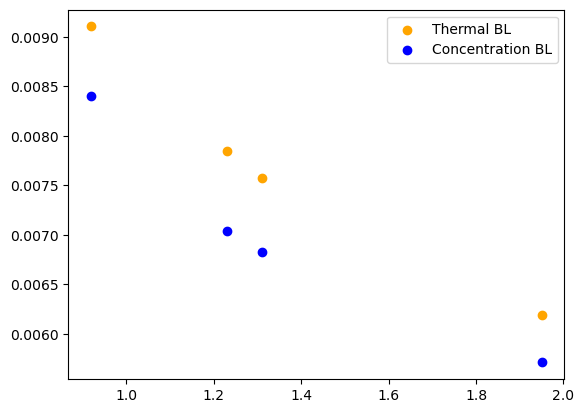

In [115]:
air_velocities = COMSOL_para['air velocity (m/s)'][::-1]
conc_BLs = [avg_concentration_BL_123, avg_concentration_BL_128, avg_concentration_BL_133, avg_concentration_BL_140]
thermal_BLs = [avg_thermal_BL_123, avg_thermal_BL_128, avg_thermal_BL_133, avg_thermal_BL_140]
plt.scatter(air_velocities, thermal_BLs, color="orange", label="Thermal BL")
plt.scatter(air_velocities, conc_BLs, color="blue", label="Concentration BL")
plt.legend()

Perform linear regression on the log values.

Slope: -0.5122 ± 0.0033
Intercept: -2.0596
R-squared: 0.9999
p-value: 4.1634e-05
Slope: -0.5084 ± 0.0357
Intercept: -2.1006
R-squared: 0.9902
p-value: 4.8947e-03


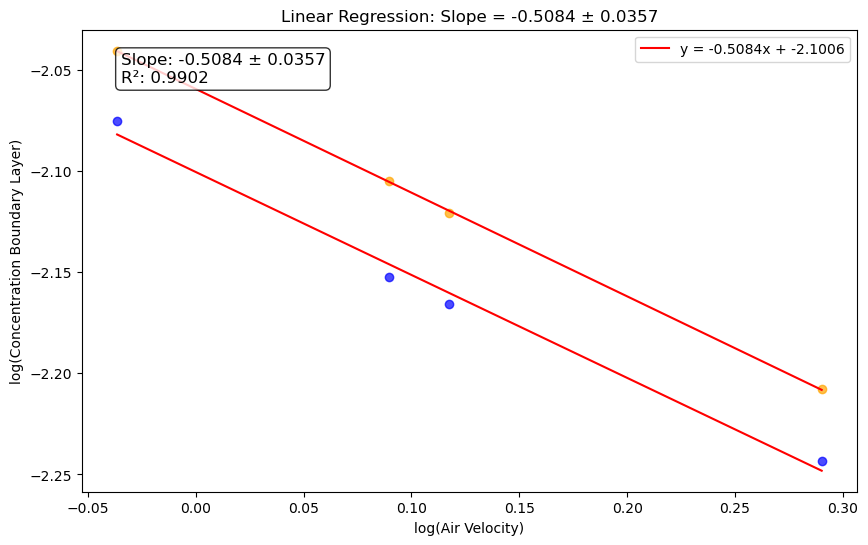

In [117]:
log_thermal_BL = np.log10(thermal_BLs)
log_conc_BL = np.log10(conc_BLs)
log_air_velocity = np.log10(air_velocities)

# Create plot
plt.figure(figsize=(10, 6))
plt.scatter(log_air_velocity, log_conc_BL, color='blue', alpha=0.7)
plt.plot(log_air_velocity, intercept + slope*log_air_velocity, 'r-', 
         label=f'y = {slope:.4f}x + {intercept:.4f}')

# Customize plot
plt.xlabel('log(Air Velocity)')
plt.ylabel('log(Concentration Boundary Layer)')
plt.title(f'Linear Regression: Slope = {slope:.4f} ± {std_err:.4f}')
plt.legend()

# Optional: Add text with regression statistics on the plot
plt.text(0.05, 0.95, f'Slope: {slope:.4f} ± {std_err:.4f}\nR²: {r_value**2:.4f}', 
         transform=plt.gca().transAxes, fontsize=12, 
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))


slope, intercept, r_value, p_value, std_err = stats.linregress(log_air_velocity, log_thermal_BL)

# Print results
print(f"Slope: {slope:.4f} ± {std_err:.4f}")
print(f"Intercept: {intercept:.4f}")
print(f"R-squared: {r_value**2:.4f}")
print(f"p-value: {p_value:.4e}")

# Create plot
plt.scatter(log_air_velocity, log_thermal_BL, color='orange', alpha=0.7)
plt.plot(log_air_velocity, intercept + slope*log_air_velocity, 'r-', 
         label=f'y = {slope:.4f}x + {intercept:.4f}')
slope, intercept, r_value, p_value, std_err = stats.linregress(log_air_velocity, log_conc_BL)

# Print results
print(f"Slope: {slope:.4f} ± {std_err:.4f}")
print(f"Intercept: {intercept:.4f}")
print(f"R-squared: {r_value**2:.4f}")
print(f"p-value: {p_value:.4e}")



# Question 3
Calculate the mass transfer coefficient $k_m$ as a function of the distance along the water tray
for one of the inlet velocities studied in the experiment. As mentioned in Eq. (4), the ratio
of mass flux to concentration difference driving force defines the mass transfer coefficient.
Explain the trend and what you expect based on theory, and the physical reasoning of such
trends. Here again avoid nonlinear fits and instead linearize your equations so as to enable
use of linear least-squares regression.

$$N_A = K_{mA} \Delta c_A$$    
(Equation 4)

#### Determining $K_{mA}$

In [121]:
df_140_flux.head()

,x (m),y (m),T (K),c (mol/m^3),molar flux
0,0.0,0.000000,323.20556,0.1165,-0.024828
1,0.0,0.000148,323.20556,0.0000,-0.025991
2,0.0,0.000326,323.20556,0.0000,0.000265
3,0.0,0.000613,323.20556,0.0000,0.000190
4,0.0,0.001083,323.20556,0.0000,0.000150


In [122]:
df_140.head()

,x (m),y (m),T (K),c (mol/m^3)
0,0.000000,0.000613,323.205560,0.000000
1,0.000000,0.000326,323.205560,0.000000
2,0.000420,0.000508,323.204494,0.000110
3,0.000567,0.000837,323.204072,0.000107
4,0.000000,0.001083,323.205560,0.000000


In [131]:
df_140_filtered = df_140.loc[df_140.groupby("x (m)")["T (K)"].idxmax()]
print(df_140_filtered)


df_140_flux_filtered = df_140_flux[df_140_flux["y (m)"] == 0]
print(df_140_flux_filtered)

          x (m)     y (m)       T (K)  c (mol/m^3)
0      0.000000  0.000613  323.205560     0.000000
2      0.000420  0.000508  323.204494     0.000110
3      0.000567  0.000837  323.204072     0.000107
895    0.000700  0.000329  323.148623     0.011460
5      0.000741  0.001377  323.204897     0.000019
...         ...       ...         ...          ...
890    0.554255  0.001326  318.406758     0.186287
11648  0.554300  0.000304  316.844825     0.222276
892    0.554417  0.000748  317.538746     0.206652
893    0.554491  0.000494  317.143796     0.215698
862    0.555000  0.018700  323.205663    -0.000002

[11525 rows x 4 columns]
        x (m)  y (m)       T (K)  c (mol/m^3)  molar flux
0    0.000000    0.0  323.205560       0.1165   -0.024828
20   0.000700    0.0  316.921698       0.2330   -0.026502
21   0.001400    0.0  316.549989       0.2330   -0.018673
22   0.002100    0.0  316.641206       0.2330   -0.014541
23   0.002799    0.0  316.600938       0.2330   -0.012671
..        ... 

In [130]:
merged_df = pd.merge(df_140_flux_filtered, df_140_filtered, on="x (m)")
merged_df = merged_df.drop(columns=["y (m)_y", "T (K)_y", "y (m)_x", "T (K)_x"])
merged_df = merged_df.rename(columns={
    "c (mol/m^3)_x": "c_0",
    "c (mol/m^3)_y": "c_b"
})
merged_df

,x (m),c_0,molar flux,c_b
0,0.000000,0.1165,-0.024828,0.000000
1,0.000700,0.2330,-0.026502,0.011460
2,0.001400,0.2330,-0.018673,0.041345
3,0.002100,0.2330,-0.014541,0.067353
4,0.002799,0.2330,-0.012671,0.084988
...,...,...,...,...
789,0.552201,0.2330,-0.000955,0.220864
790,0.552900,0.2330,-0.000954,0.221473
791,0.553600,0.2330,-0.000953,0.222011
792,0.554300,0.2330,-0.000948,0.222276


#### Define a function that will calculate $k_m$

In [132]:
def determine_mt_coeff(flux, c_0, c_b):
    return flux/(c_0 - c_b)

#### Calculation of $k_m(x)$

In [138]:
merged_df["mt_coeff"] = merged_df.apply(
    lambda row: determine_mt_coeff(row["molar flux"], row["c_0"], row["c_b"]), axis=1
)
mt_df = merged_df
mt_df

,x (m),c_0,molar flux,c_b,mt_coeff
0,0.000000,0.1165,-0.024828,0.000000,-0.213116
1,0.000700,0.2330,-0.026502,0.011460,-0.119625
2,0.001400,0.2330,-0.018673,0.041345,-0.097432
3,0.002100,0.2330,-0.014541,0.067353,-0.087786
4,0.002799,0.2330,-0.012671,0.084988,-0.085610
...,...,...,...,...,...
789,0.552201,0.2330,-0.000955,0.220864,-0.078691
790,0.552900,0.2330,-0.000954,0.221473,-0.082763
791,0.553600,0.2330,-0.000953,0.222011,-0.086726
792,0.554300,0.2330,-0.000948,0.222276,-0.088397


#### Visualization

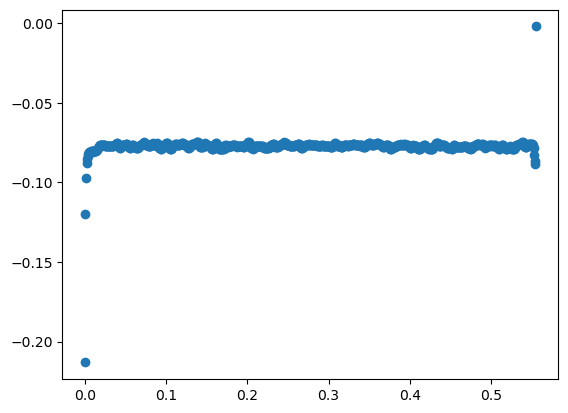

In [137]:
plt.scatter(mt_df["x (m)"], mt_df["mt_coeff"])